Import Library

In [ ]:
!pip install keras-segmentation

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.3/753.3 kB 52.4 MB/s eta 0:00:00
  Created wheel for keras-segmentation: filename=keras_segmentation-0.3.0-py3-none-any.whl size=29057 sha256=8519c7efdfcdd4c33d034dfd0439b432161dd95220bc90cbaa55117c210f895b
  Stored in directory: /root/.cache/pip/wheels/2a/87/5b/ddc104c262fe1280e0565a2cc1b9b6b04963af12e462cdf068
Successfully built keras-segmentation
  Attempting uninstall: imageio
    Found existing installation: imageio 2.31.6
    Uninstalling imageio-2.31.6:
      Successfully uninstalled imageio-2.31.6
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.4.0
    Uninstalling imgaug-0.4.0:
      Successfully uninstalled imgaug-0.4.0


In [ ]:
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import os
import cv2
import keras
import keras.backend as K
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint
from keras_segmentation.models.unet import vgg_unet

Prepare Datasets

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/Dataset"

In [ ]:
def imshow(image):
  plt.imshow(image)
  plt.show()

In [ ]:
files = os.listdir(DATA_PATH)
len(files)

4

In [ ]:
train_img_path = os.path.join(DATA_PATH, 'images_prepped_train-20230811T065243Z-001', 'images_prepped_train')
train_annot_path = os.path.join(DATA_PATH, 'annotations_prepped_train-20230811T065240Z-001', 'annotations_prepped_train')

test_img_path = os.path.join(DATA_PATH, 'images_prepped_test-20230811T065241Z-001', 'images_prepped_test')
test_annot_path = os.path.join(DATA_PATH, 'annotations_prepped_test-20230811T065240Z-001', 'annotations_prepped_test')

In [ ]:
print(f'total train images: {len(os.listdir(train_img_path))}')
print(f'total train annots: {len(os.listdir(train_annot_path))}')
print(f'total test images: {len(os.listdir(test_img_path))}')
print(f'total test annots: {len(os.listdir(test_annot_path))}')

total train images: 367
total train annots: 367
total test images: 101
total test annots: 101


In [ ]:
def get_classes_annotations(annotation_folder):
    # Initialize an empty set to accumulate unique classes
    unique_classes_set = set()

    # Iterate through each file in the folder
    for filename in os.listdir(annotation_folder):
        if filename.endswith('.png'):  # Assuming images are in PNG format, adjust as needed
            # Load the annotation image
            annotation_path = os.path.join(annotation_folder, filename)
            annotation_image = Image.open(annotation_path)

            # Convert the image to a NumPy array
            annotation_array = np.array(annotation_image)

            # Add unique classes to the set
            unique_classes_set.update(np.unique(annotation_array))

    # Print the number of unique classes and the unique class values
    number_of_classes = len(unique_classes_set)
    unique_classes_values = sorted(list(unique_classes_set))

    print("Number of Unique Classes:", number_of_classes)
    print("Unique Class Values:", unique_classes_values)

In [ ]:
get_classes_annotations(train_annot_path)

Number of Unique Classes: 12
Unique Class Values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


In [ ]:
get_classes_annotations(test_annot_path)

Number of Unique Classes: 12
Unique Class Values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


Data Cleaning

In [ ]:
def get_image_no_annot(imgs_path, annots_path):
    paths = []
    for img_path in os.listdir(imgs_path):
        if img_path not in os.listdir(annots_path):
            paths.append(img_path)
    return paths

In [ ]:
no_annot_imgs = get_image_no_annot(train_img_path, train_annot_path)

In [ ]:
print(no_annot_imgs)

[]


In [ ]:
def remove_image_no_annot(imgs_path, no_annot_imgs):
    for img in no_annot_imgs:
        file_path = os.path.join(imgs_path, img)
        if os.path.exists(file_path):
            os.remove(file_path)
            print(f"File at {file_path} has been removed.")
        else:
            print(f"File at {file_path} does not exist.")

In [ ]:
remove_image_no_annot(train_img_path, no_annot_imgs)

In [ ]:
print(f'total train images: {len(os.listdir(train_img_path))}')
print(f'total train annots: {len(os.listdir(train_annot_path))}')
print(f'total test images: {len(os.listdir(test_img_path))}')
print(f'total test annots: {len(os.listdir(test_annot_path))}')

total train images: 367
total train annots: 367
total test images: 101
total test annots: 101


In [ ]:
from keras_segmentation.data_utils.data_loader import image_segmentation_generator, verify_segmentation_dataset

In [ ]:
verify_segmentation_dataset(train_img_path, train_annot_path, 12)

100%|██████████| 367/367 [00:12<00:00, 29.46it/s]

Dataset verified! 


True

Processing Data

In [ ]:
def patch_image(image, height_patch, width_patch):
    image_height, image_width, _ = image.shape
    num_patches_height = image_height // height_patch
    num_patches_width = image_width // width_patch

    patched_image = np.empty((num_patches_height, num_patches_width, height_patch, width_patch, 3))

    for i in range(num_patches_height):
        for j in range(num_patches_width):
            patch = image[i * height_patch: (i + 1) * height_patch, j * width_patch: (j + 1) * width_patch, :]
            patched_image[i, j] = patch

    return patched_image

In [ ]:
def patch_to_grayscale(patched_image):
    num_patches_height, num_patches_width, height_patch, width_patch, _ = patched_image.shape

    patched_grayscale = np.zeros((num_patches_height, num_patches_width, height_patch, width_patch), dtype=np.uint8)

    for i in range(num_patches_height):
        for j in range(num_patches_width):
            patch = patched_image[i,j]
            patch_grayscale = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)
            patched_grayscale[i,j] = patch_grayscale

    return patched_grayscale

In [ ]:
def combine_patches(patched_image):
    num_patches_height, num_patches_width, height_patch, width_patch, channels = patched_image.shape

    if channels == 1:
        combined_image = np.empty((num_patches_height * height_patch, num_patches_width * width_patch))
    else:
        combined_image = np.empty((num_patches_height * height_patch, num_patches_width * width_patch, channels))

    for i in range(num_patches_height):
        for j in range(num_patches_width):
            patch = patched_image[i, j]
            combined_image[i * height_patch: (i + 1) * height_patch, j * width_patch: (j + 1) * width_patch] = patch

    return combined_image

In [ ]:
def preprocess_image(x):
    return patch_to_grayscale(patch_image(x, 176, 240))

In [ ]:
train_gen = image_segmentation_generator(
        train_img_path, train_annot_path,  2,  12,
        480, 352, 240, 176)

In [ ]:
test_gen = image_segmentation_generator(
        test_img_path, test_annot_path,  2,  12,
        480, 352, 240, 176)

Train

In [ ]:
default_callback = ModelCheckpoint(
                filepath='/tmp/vgg_unet' + ".{epoch:05d}",
                save_weights_only=True,
                save_best_only=True,
                verbose=True
            )

callbacks = [default_callback]

In [ ]:
#Keras
def DiceLoss(targets, inputs, smooth=1e-6):
    # Flatten label and prediction tensors
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)

    intersection = K.sum(targets * inputs)
    dice = (2 * intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    return 1 - dice

In [ ]:
model_vgg_unet = vgg_unet(n_classes=12, input_height=352, input_width=480)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model_vgg_unet.compile(
    optimizer='adam',
    loss=DiceLoss,
    metrics=['accuracy']
)

In [ ]:
model_vgg_unet.fit(train_gen,
                  steps_per_epoch=100,
                  validation_data=test_gen,
                  validation_steps=100,
                  epochs=10, callbacks=callbacks)

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.4094 - accuracy: 0.6053 
Epoch 1: val_loss improved from inf to 0.64388, saving model to /tmp/vgg_unet.00001
100/100 [==============================] - 2167s 22s/step - loss: 0.4094 - accuracy: 0.6053 - val_loss: 0.6439 - val_accuracy: 0.3867
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.2975 - accuracy: 0.7072 
Epoch 2: val_loss improved from 0.64388 to 0.36501, saving model to /tmp/vgg_unet.00002
100/100 [==============================] - 2198s 22s/step - loss: 0.2975 - accuracy: 0.7072 - val_loss: 0.3650 - val_accuracy: 0.6381
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.2624 - accuracy: 0.7410 
Epoch 3: val_loss improved from 0.36501 to 0.32628, saving model to /tmp/vgg_unet.00003
100/100 [==============================] - 2197s 22s/step - loss: 0.2624 - accuracy: 0.7410 - val_loss: 0.3263 - val_accuracy: 0.6764
Epoch 4/10
100/100 [===========================

In [ ]:
import random
from time import time

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
class_colors = [(random.randint(0, 255), random.randint(
    0, 255), random.randint(0, 255)) for _ in range(5000)]

In [ ]:
# cityscapes_classes = [
#     'Unlabeled', 'Road', 'Sidewalk', 'Building', 'Wall', 'Fence', 'Pole',
#     'Traffic Light', 'Traffic Sign', 'Vegetation', 'Terrain', 'Sky', 'Person',
#     'Rider', 'Car', 'Truck', 'Bus', 'Train', 'Motorcycle', 'Bicycle',
#     'Void', 'Caravan', 'Trailer', 'Train', 'Tram', 'Truck', 'Van', 'Others',
#     'Building_Pole', 'Traffic Sign Pole', 'Traffic Light Pole'
# ]

cityscapes_classes = [
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'
]

In [ ]:
def show_sample_predictions(model, original_img_paths, true_annot_paths, true_img, pred_path):
    start = time()

    input_image = os.path.join(original_img_paths, true_img)
    out = model.predict_segmentation(
        inp=input_image,
        out_fname=pred_path,
        overlay_img=True, show_legends=True,
        class_names=cityscapes_classes,
        colors=class_colors
    )

    fig, axs = plt.subplots(1, 3, figsize=(40, 40), constrained_layout=True)

    img_orig = Image.open(input_image)
    axs[0].imshow(img_orig)
    axs[0].set_title(f'original {true_img}')
    axs[0].grid(False)

    axs[1].imshow(out)
    axs[1].set_title(f'prediction {true_img}')
    axs[1].grid(False)

    validation_image = os.path.join(true_annot_paths, true_img)
    axs[2].imshow( Image.open(validation_image))
    axs[2].set_title(f'true label {pred_path}')
    axs[2].grid(False)


    done = time()
    elapsed = done - start

In [ ]:
model_vgg_unet.evaluate_segmentation(
    inp_images_dir=test_img_path,
    annotations_dir=test_annot_path
)

0it [00:00, ?it/s]

1/1 [==============================] - 2s 2s/step


1it [00:02,  2.91s/it]

1/1 [==============================] - 3s 3s/step


2it [00:06,  3.24s/it]

1/1 [==============================] - 2s 2s/step


3it [00:08,  2.95s/it]

1/1 [==============================] - 3s 3s/step


4it [00:11,  2.97s/it]

1/1 [==============================] - 3s 3s/step


5it [00:17,  3.80s/it]

1/1 [==============================] - 3s 3s/step


6it [00:22,  4.28s/it]

1/1 [==============================] - 2s 2s/step


7it [00:25,  3.75s/it]

1/1 [==============================] - 2s 2s/step


8it [00:27,  3.41s/it]

1/1 [==============================] - 3s 3s/step


9it [00:33,  3.99s/it]

1/1 [==============================] - 3s 3s/step


10it [00:38,  4.38s/it]

1/1 [==============================] - 2s 2s/step


11it [00:40,  3.66s/it]

1/1 [==============================] - 2s 2s/step


12it [00:43,  3.36s/it]

1/1 [==============================] - 2s 2s/step


13it [00:45,  2.96s/it]

1/1 [==============================] - 2s 2s/step


14it [00:47,  2.68s/it]

1/1 [==============================] - 3s 3s/step


15it [00:52,  3.46s/it]

1/1 [==============================] - 2s 2s/step


16it [00:54,  3.21s/it]

1/1 [==============================] - 2s 2s/step


17it [00:57,  3.05s/it]

1/1 [==============================] - 2s 2s/step


18it [01:00,  2.94s/it]

1/1 [==============================] - 2s 2s/step


19it [01:02,  2.74s/it]

1/1 [==============================] - 3s 3s/step


20it [01:07,  3.50s/it]

1/1 [==============================] - 2s 2s/step


21it [01:09,  3.06s/it]

1/1 [==============================] - 2s 2s/step


22it [01:12,  2.94s/it]

1/1 [==============================] - 2s 2s/step


23it [01:15,  2.85s/it]

1/1 [==============================] - 2s 2s/step


24it [01:17,  2.79s/it]

1/1 [==============================] - 3s 3s/step


25it [01:23,  3.53s/it]

1/1 [==============================] - 2s 2s/step


26it [01:25,  3.08s/it]

1/1 [==============================] - 2s 2s/step


27it [01:27,  2.96s/it]

1/1 [==============================] - 2s 2s/step


28it [01:29,  2.69s/it]

1/1 [==============================] - 2s 2s/step


29it [01:32,  2.68s/it]

1/1 [==============================] - 3s 3s/step


30it [01:35,  2.86s/it]

1/1 [==============================] - 3s 3s/step


31it [01:38,  2.86s/it]

1/1 [==============================] - 2s 2s/step


32it [01:40,  2.61s/it]

1/1 [==============================] - 2s 2s/step


33it [01:42,  2.45s/it]

1/1 [==============================] - 2s 2s/step


34it [01:45,  2.51s/it]

1/1 [==============================] - 2s 2s/step


35it [01:47,  2.37s/it]

1/1 [==============================] - 3s 3s/step


36it [01:52,  3.22s/it]

1/1 [==============================] - 2s 2s/step


37it [01:55,  3.06s/it]

1/1 [==============================] - 2s 2s/step


38it [01:57,  2.76s/it]

1/1 [==============================] - 2s 2s/step


39it [02:00,  2.73s/it]

1/1 [==============================] - 2s 2s/step


40it [02:02,  2.71s/it]

1/1 [==============================] - 3s 3s/step


41it [02:08,  3.48s/it]

1/1 [==============================] - 2s 2s/step


42it [02:10,  3.23s/it]

1/1 [==============================] - 2s 2s/step


43it [02:12,  2.88s/it]

1/1 [==============================] - 2s 2s/step


44it [02:14,  2.63s/it]

1/1 [==============================] - 2s 2s/step


45it [02:17,  2.64s/it]

1/1 [==============================] - 3s 3s/step


46it [02:20,  2.88s/it]

1/1 [==============================] - 3s 3s/step


47it [02:23,  2.93s/it]

1/1 [==============================] - 2s 2s/step


48it [02:26,  2.85s/it]

1/1 [==============================] - 2s 2s/step


49it [02:29,  2.79s/it]

1/1 [==============================] - 2s 2s/step


50it [02:31,  2.75s/it]

1/1 [==============================] - 2s 2s/step


51it [02:34,  2.60s/it]

1/1 [==============================] - 3s 3s/step


52it [02:39,  3.39s/it]

1/1 [==============================] - 2s 2s/step


53it [02:42,  3.18s/it]

1/1 [==============================] - 2s 2s/step


54it [02:44,  3.02s/it]

1/1 [==============================] - 2s 2s/step


55it [02:47,  2.91s/it]

1/1 [==============================] - 2s 2s/step


56it [02:50,  2.84s/it]

1/1 [==============================] - 3s 3s/step


57it [02:55,  3.56s/it]

1/1 [==============================] - 2s 2s/step


58it [02:57,  3.28s/it]

1/1 [==============================] - 2s 2s/step


59it [02:59,  2.91s/it]

1/1 [==============================] - 2s 2s/step


60it [03:02,  2.83s/it]

1/1 [==============================] - 2s 2s/step


61it [03:05,  2.78s/it]

1/1 [==============================] - 3s 3s/step


62it [03:10,  3.52s/it]

1/1 [==============================] - 2s 2s/step


63it [03:13,  3.26s/it]

1/1 [==============================] - 2s 2s/step


64it [03:15,  3.08s/it]

1/1 [==============================] - 2s 2s/step


65it [03:18,  2.95s/it]

1/1 [==============================] - 3s 3s/step


66it [03:23,  3.63s/it]

1/1 [==============================] - 2s 2s/step


67it [03:26,  3.34s/it]

1/1 [==============================] - 2s 2s/step


68it [03:28,  3.13s/it]

1/1 [==============================] - 2s 2s/step


69it [03:31,  2.80s/it]

1/1 [==============================] - 2s 2s/step


70it [03:32,  2.55s/it]

1/1 [==============================] - 3s 3s/step


71it [03:35,  2.69s/it]

1/1 [==============================] - 3s 3s/step


72it [03:41,  3.67s/it]

1/1 [==============================] - 2s 2s/step


73it [03:44,  3.19s/it]

1/1 [==============================] - 2s 2s/step


74it [03:46,  3.03s/it]

1/1 [==============================] - 2s 2s/step


75it [03:49,  2.92s/it]

1/1 [==============================] - 3s 3s/step


76it [03:54,  3.61s/it]

1/1 [==============================] - 2s 2s/step


77it [03:57,  3.32s/it]

1/1 [==============================] - 2s 2s/step


78it [03:59,  2.94s/it]

1/1 [==============================] - 2s 2s/step


79it [04:01,  2.86s/it]

1/1 [==============================] - 2s 2s/step


80it [04:04,  2.80s/it]

1/1 [==============================] - 3s 3s/step


81it [04:09,  3.54s/it]

1/1 [==============================] - 2s 2s/step


82it [04:11,  3.07s/it]

1/1 [==============================] - 2s 2s/step


83it [04:13,  2.76s/it]

1/1 [==============================] - 2s 2s/step


84it [04:15,  2.54s/it]

1/1 [==============================] - 2s 2s/step


85it [04:18,  2.58s/it]

1/1 [==============================] - 3s 3s/step


86it [04:21,  2.70s/it]

1/1 [==============================] - 3s 3s/step


87it [04:26,  3.47s/it]

1/1 [==============================] - 2s 2s/step


88it [04:29,  3.22s/it]

1/1 [==============================] - 2s 2s/step


89it [04:32,  3.05s/it]

1/1 [==============================] - 2s 2s/step


90it [04:34,  2.93s/it]

1/1 [==============================] - 3s 3s/step


91it [04:37,  2.98s/it]

1/1 [==============================] - 3s 3s/step


92it [04:41,  3.07s/it]

1/1 [==============================] - 2s 2s/step


93it [04:43,  2.82s/it]

1/1 [==============================] - 2s 2s/step


94it [04:45,  2.56s/it]

1/1 [==============================] - 2s 2s/step


95it [04:47,  2.59s/it]

1/1 [==============================] - 2s 2s/step


96it [04:50,  2.61s/it]

1/1 [==============================] - 3s 3s/step


97it [04:55,  3.39s/it]

1/1 [==============================] - 2s 2s/step


98it [04:57,  2.99s/it]

1/1 [==============================] - 2s 2s/step


99it [04:59,  2.71s/it]

1/1 [==============================] - 2s 2s/step


100it [05:01,  2.51s/it]

1/1 [==============================] - 2s 2s/step


101it [05:04,  3.02s/it]


{'frequency_weighted_IU': 0.6130267374753129,
 'mean_IU': 0.2798644079497355,
 'class_wise_IU': array([0.93288555, 0.77718853, 0.        , 0.71086008, 0.        ,
        0.70478887, 0.        , 0.        , 0.23264986, 0.        ,
        0.        , 0.        ])}

1/1 [==============================] - 3s 3s/step


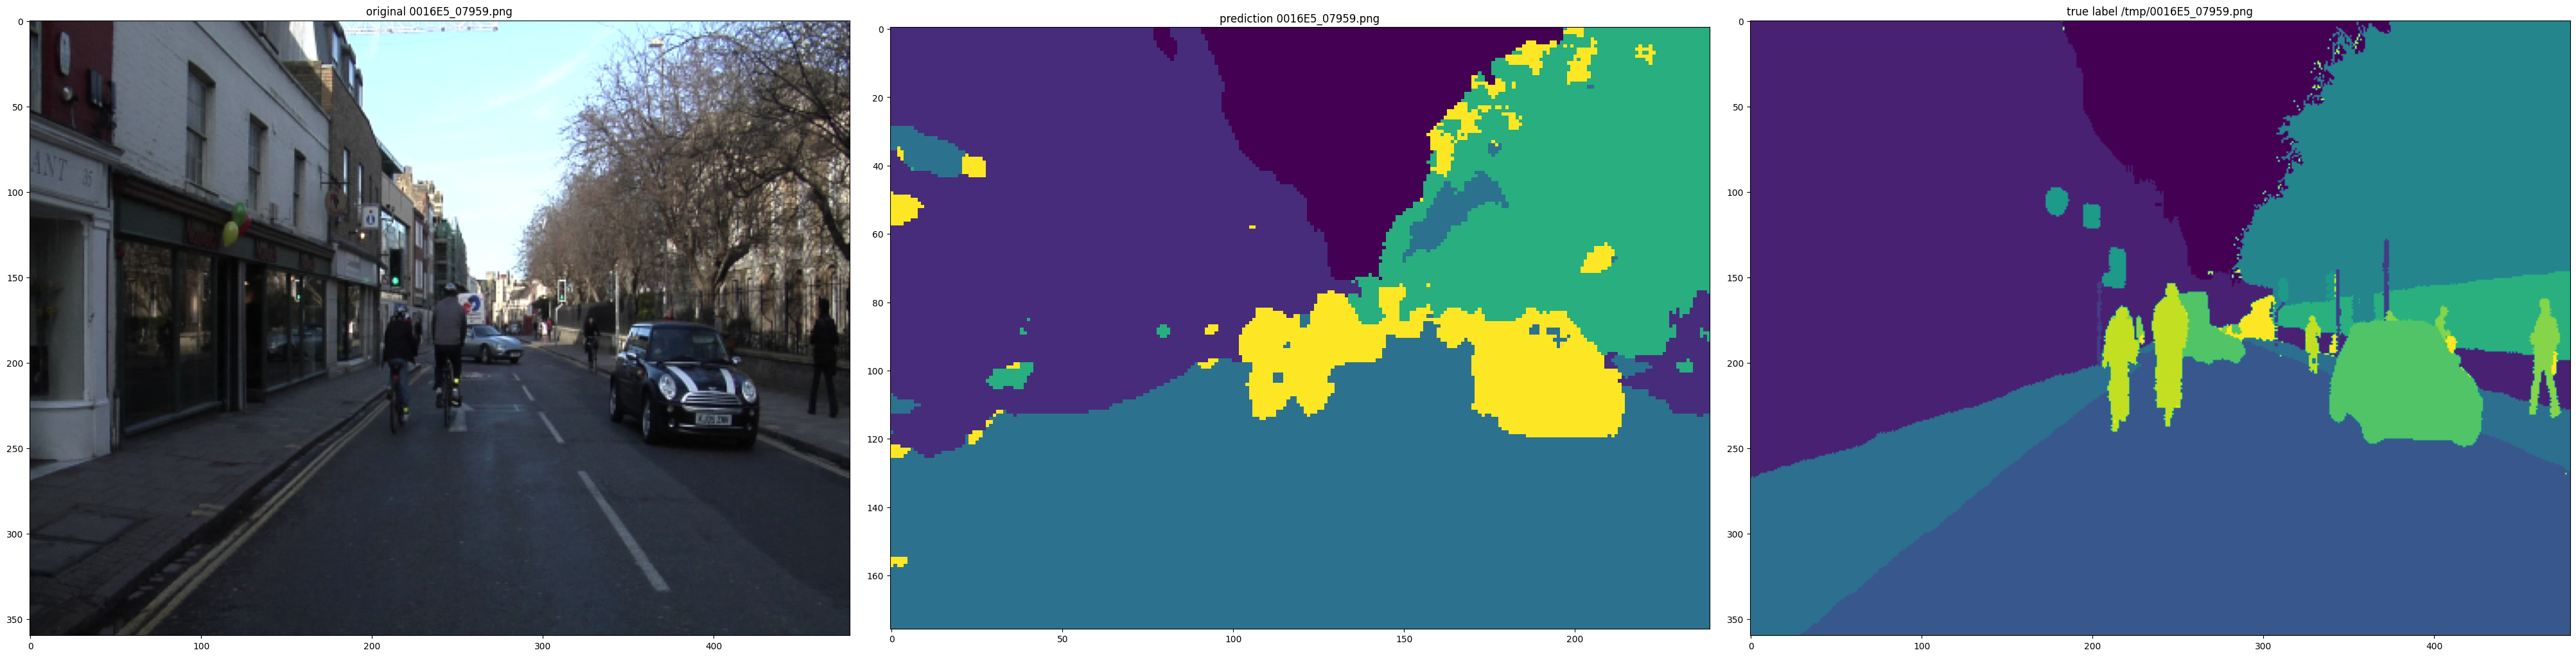

In [ ]:
show_sample_predictions(model_vgg_unet, test_img_path, test_annot_path, '0016E5_07959.png', '/tmp/0016E5_07959.png')

1/1 [==============================] - 2s 2s/step


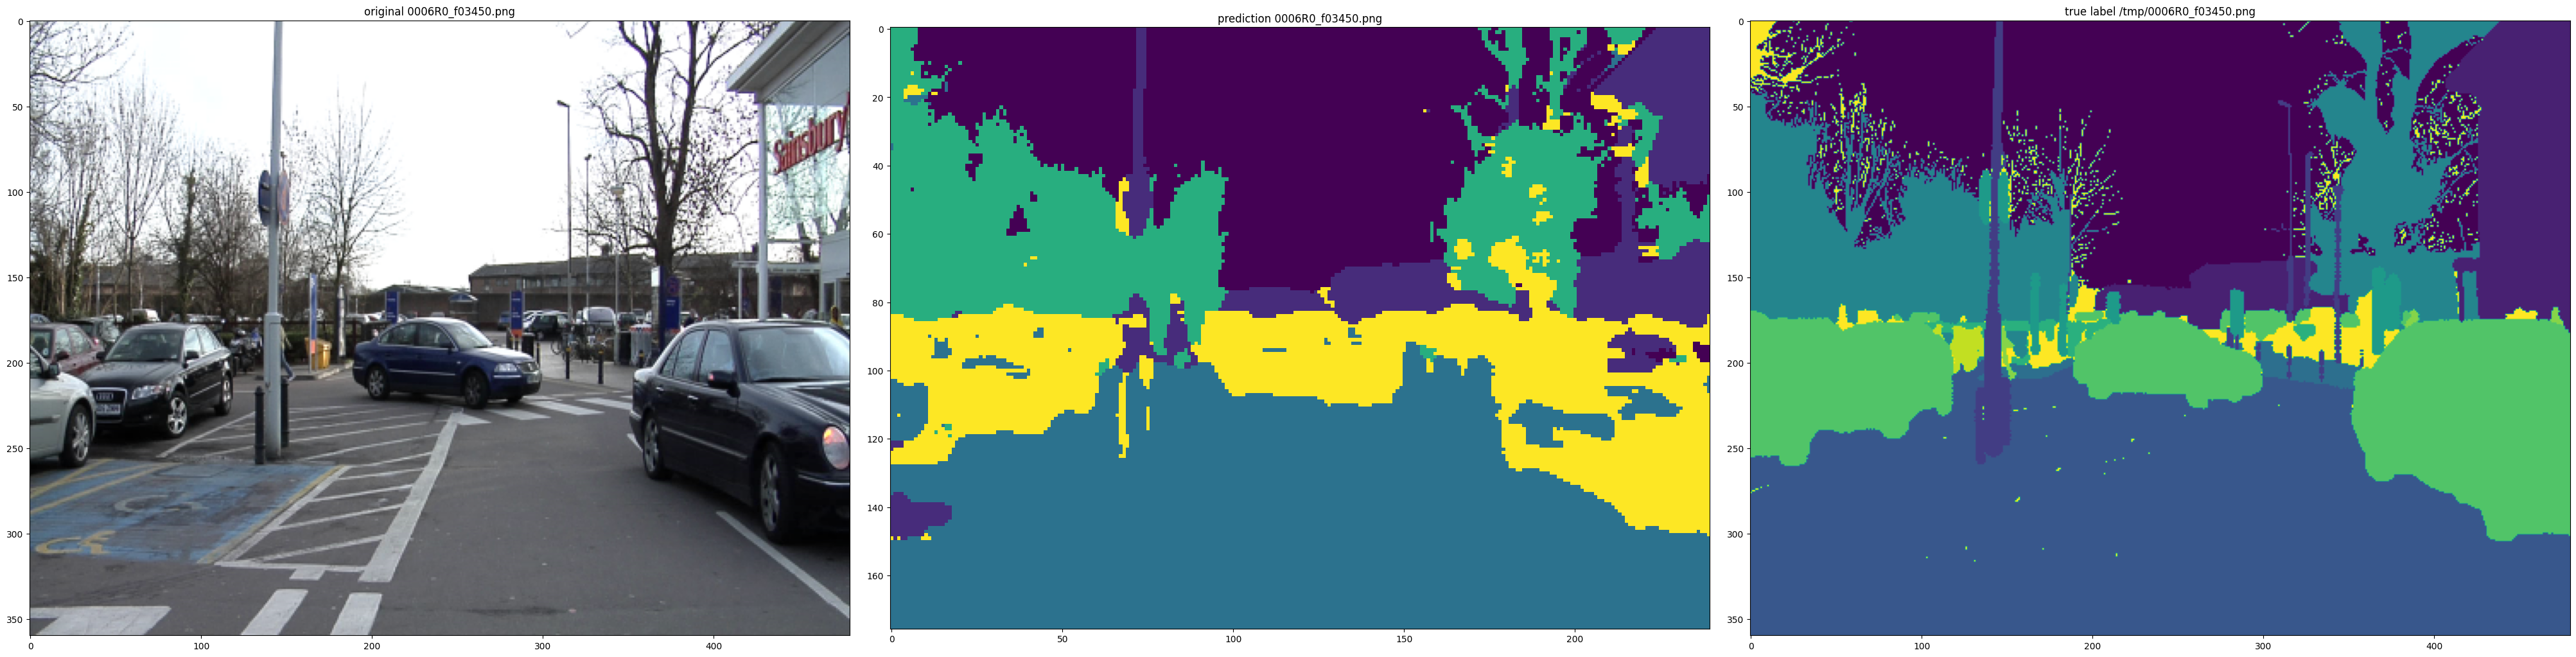

In [ ]:
show_sample_predictions(model_vgg_unet, train_img_path, train_annot_path, '0006R0_f03450.png', '/tmp/0006R0_f03450.png')

1/1 [==============================] - 2s 2s/step


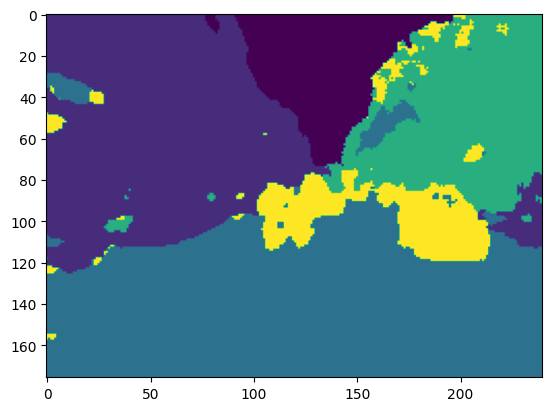

In [ ]:
out = model_vgg_unet.predict_segmentation(
    inp=os.path.join(test_img_path, "0016E5_07959.png"),
    out_fname="/tmp/out.png",
    overlay_img=True, show_legends=True,
    class_names=cityscapes_classes
)

plt.imshow(out)